# <b>MIBTP masterclass 2021 - DNaseI-Seq analysis with DESeq2</b>

In this part of the practical we will carry out a differential DHS analysis using the DESeq2 package in R. DESeq2 was originally developed for RNA-Seq analysis from count data but is can also be used with count data from other sources such as DNaseI-Seq or ATAC-Seq

In [1]:
# Load the libraries that we will need for this workshop
suppressMessages(library(DESeq2))
suppressMessages(library(limma))
library(ggplot2)
library(pheatmap)

Set you working directory to the same folder you used in part 1

In [ ]:
setwd('/rds/projects/k/knowletj-mibtp-masterclasses/MITBP_Masterclass_2021/YOUR_NAME')

## <b>Step 1. Reading data from featureCounts and processing them with DESeq2</b>

In [2]:
# Read raw count data from featureCounts and re-format the data to something more suitable for DESeq2
rawCounts<- read.delim('rawCounts/TAgNAg_rawCounts.tsv', header = TRUE, comment.char = '#', row.names = 1)

# Print the first few lines
head(rawCounts)

,Chr,Start,End,Strand,Length,...alignments.NAg_Rep1_rmdup.bam,...alignments.NAg_Rep2_rmdup.bam,...alignments.TAg_Rep1_rmdup.bam,...alignments.TAg_Rep2_rmdup.bam
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>
chr1:4785546:4785946,chr1,4785546,4785946,.,401,43,96,85,53
chr1:4807622:4808022,chr1,4807622,4808022,.,401,22,58,57,42
chr1:4857536:4857936,chr1,4857536,4857936,.,401,14,44,53,38
chr1:4858473:4858873,chr1,4858473,4858873,.,401,24,35,29,27
chr1:5082782:5083182,chr1,5082782,5083182,.,401,33,64,41,21
chr1:6214394:6214794,chr1,6214394,6214794,.,401,19,43,57,26


The table from featureCounts contains more information than we need and in order to read this into DESeq2 we will need to remove these extra columns
Here we will extract only the columns that contain the count data (columns 6 to 9) and re-name them into something easier to read

In [3]:
# Keep only columns 6 to 9
rawCounts<- rawCounts[,6:9]

# Rename the columns to something more human readable
colnames(rawCounts)<- c('NAg_Rep1', 'NAg_Rep2', 'TAg_Rep1', 'TAg_Rep2')

# Show the first few rows to see what the table looks like now
head(rawCounts)

,NAg_Rep1,NAg_Rep2,TAg_Rep1,TAg_Rep2
,<int>,<int>,<int>,<int>
chr1:4785546:4785946,43,96,85,53
chr1:4807622:4808022,22,58,57,42
chr1:4857536:4857936,14,44,53,38
chr1:4858473:4858873,24,35,29,27
chr1:5082782:5083182,33,64,41,21
chr1:6214394:6214794,19,43,57,26


In [4]:
# Create a table that will contain the sample annotation data
# We will use this table to tell DESeq2 how our data is arranged and what samples we wish to compare

colData<- data.frame(sampleID = colnames(rawCounts), 
                     condition = factor(c('NAg', 'NAg', 'TAg', 'TAg')), 
                     replicate = factor(c('Rep1', 'Rep2', 'Rep1', 'Rep2')))
colData

sampleID,condition,replicate
<chr>,<fct>,<fct>
NAg_Rep1,NAg,Rep1
NAg_Rep2,NAg,Rep2
TAg_Rep1,TAg,Rep1
TAg_Rep2,TAg,Rep2


In [5]:
# Read count data into DESeq2
# At the same time we provide a design forumula which will tell DESeq2 how we wish to analyze the data
# Here we are just telling DESeq2 to compare samples in different conditions

dds<- DESeqDataSetFromMatrix(countData = rawCounts, colData = colData, design = ~ condition)

# The main DESeq function
# This will normalize the data and calculate the differential peak analysis at the same time

dds<- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## <b>Step 2. Quality control - Clustering analysis of log-transformed counts from DESeq2</b>

Before we procede we should carry out some basic quality control of the data. A clustering analysis is useful here as it can easily show any potential issues with the data (such as batch effects)
Here we will carry out two different types of clustering analysis:
* Hierarchical clustering
* Principal Components Analysis (PCA)

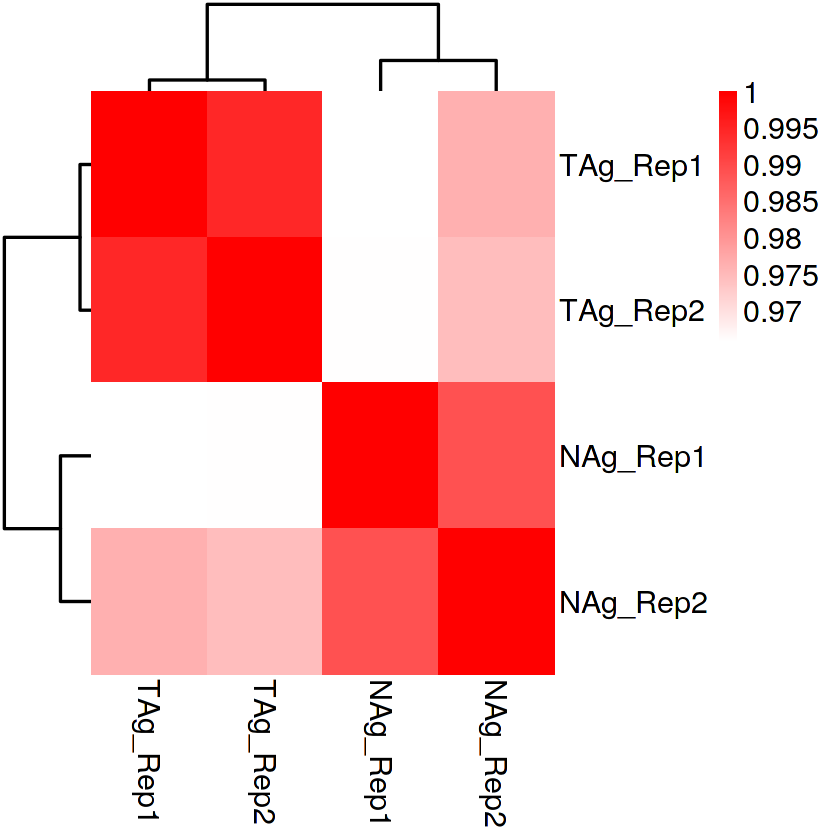

In [6]:
# Extract log2-transformed normalized counts from DESeq2
# Here we will use the rlog function from DESeq2
# This calculates the regularizes log2 transformed counts and is reccomended by the DESeq2 authors for clustering analysis
logCounts<- assay(rlog(dds))

# Calculate the pearson correlation values for each pair of samples
pCor<- cor(logCounts, method = 'pearson')

# Draw a heatmap of the correlation values with hierarchical clustering
pheatmap(pCor, border_color = NA, color = colorRampPalette(c('white', 'red'))(256), fontsize = 18, lwd = 2)

The above plot shows that samples correlate well by their replicates - this is what we would like to see

Next we will carry out a Principal Component Analyis (PCA) using the prcomp function
We will then plot the results using the ggplot2 package

In [7]:
# Principal Component analysis of the log counts
pca<- prcomp(t(logCounts))

# Extract the results from the PCA
# Also add the sample annotation data to the table - we will need this data for ggplot2
pca_results<- cbind(as.data.frame(pca$x), colData)
pca_results

,PC1,PC2,PC3,PC4,sampleID,condition,replicate
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>
NAg_Rep1,-29.57114,12.672448,-2.038090,-1.425920e-13,NAg_Rep1,NAg,Rep1
NAg_Rep2,-17.94598,-16.197861,2.628845,1.343483e-14,NAg_Rep2,NAg,Rep2
TAg_Rep1,23.71390,-1.522737,-10.864815,1.585747e-13,TAg_Rep1,TAg,Rep1
TAg_Rep2,23.80322,5.048150,10.274060,1.241312e-13,TAg_Rep2,TAg,Rep2


In [8]:
# Calculate the proportion of the variance contained in the PCs
propVar<- pca$sdev ^ 2 / sum(pca$sdev ^ 2) * 100
propVar

[1] 7.723494e+01 1.497116e+01 7.793899e+00 4.019851e-28

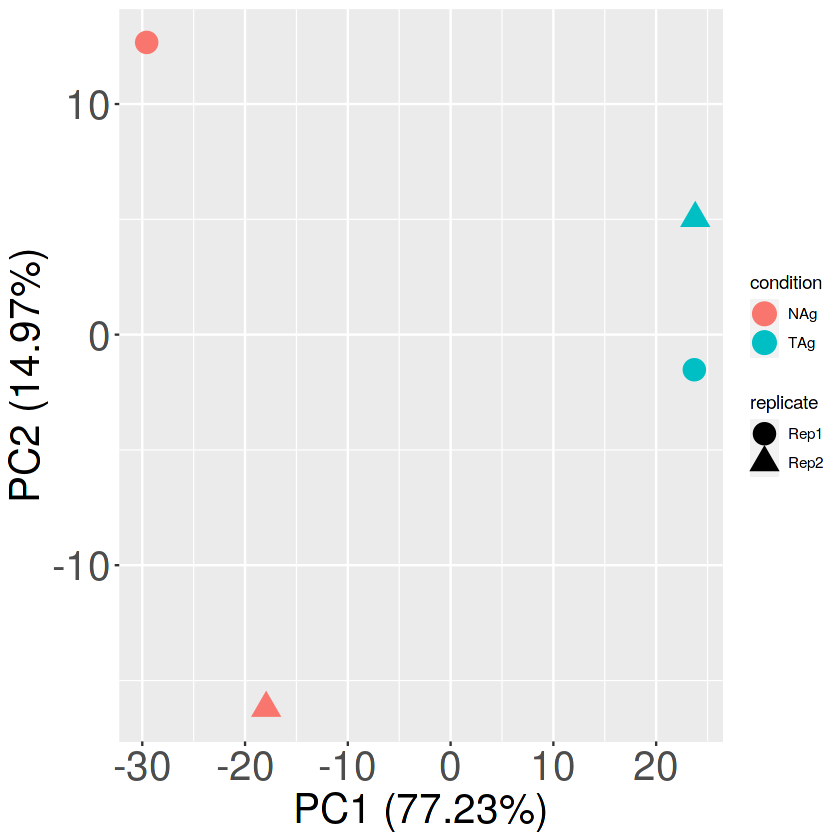

In [9]:
# Plot a PCA of the first two PCs using ggplot
g<- ggplot(pca_results, aes(x = PC1, y = PC2, shape = replicate, color = condition)) + geom_point(size = 6) +
xlab(paste('PC1 (', round(propVar[1], 2), '%)', sep = '')) + # Add proportion of variance to PC1
ylab(paste('PC2 (', round(propVar[2], 2), '%)', sep = '')) + # Add proportion of variance to PC1
theme(axis.title = element_text(size = 24), axis.text = element_text(size = 24)) # Set font size for X and Y axis

g

## <b>Step 3. Extracting significantly differential peaks</b>

In [10]:
# Get a table of results from DESEq2
resTable<- results(dds, contrast = c('condition', 'TAg', 'NAg'))

# The contrast option here tells DESeq2 what analysis we want to do
# The above command tells DESeq2 to look at the sample groups contained in the condition column of the colData table and compare the TAg and NAg groups contained there

# Convert this table to a data frame and order table by fold-change
resTable<- as.data.frame(resTable)
resTable<- resTable[order(resTable$log2FoldChange, decreasing = TRUE),]

# Have a look at the results table
head(resTable)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrY:1245574:1245974,28.06006,8.235193,1.515126,5.435320,5.469831e-08,5.350908e-06
chrY:1010035:1010435,11.15717,6.900189,1.619533,4.260605,2.038741e-05,6.968942e-04
chr2:75997709:75998109,20.72860,6.328558,1.458329,4.339594,1.427462e-05,5.236601e-04
chr17:73211254:73211654,15.72880,5.977469,1.474534,4.053801,5.039207e-05,1.430567e-03
chr12:110560816:110561216,13.35209,5.746079,1.493150,3.848294,1.189435e-04,2.830316e-03
chr15:14524284:14524684,13.34680,5.732563,1.518874,3.774218,1.605103e-04,3.566702e-03


The important columns in this table are the log2FoldChange and padj columns
padj contains the p-values which have been corrected for multiple testing

Here we will use a 2-fold cutoff for peaks with an ajusted p-value less than 0.1

In [11]:
# Get TAg and NAg specific sites
resTable.TAg_specific<- resTable[resTable$log2FoldChange > 1 & resTable$padj < 0.1,]
paste('Found', nrow(resTable.TAg_specific), 'TAg specific peaks', sep = ' ')

resTable.NAg_specific<- resTable[resTable$log2FoldChange < -1 & resTable$padj < 0.1,]
paste('Found', nrow(resTable.NAg_specific), 'NAg specific peaks', sep = ' ')

[1] "Found 1778 TAg specific peaks"

[1] "Found 2173 NAg specific peaks"

In [12]:
# The peak coordinates are stores as the row names of the resTable object
# We need to convert this to the BED format for further downstream analysis
# The strsplit2 function from limma is useful here

bed<- strsplit2(row.names(resTable), split = ':')
head(bed)

# Write results to file
write.table(bed, file = 'TAgNAg_results/TAgNAg_ordered.bed', sep = '\t', quote = FALSE, row.names = FALSE, col.names = FALSE)

chrY,1245574,1245974
chrY,1010035,1010435
chr2,75997709,75998109
chr17,73211254,73211654
chr12,110560816,110561216
chr15,14524284,14524684


In [13]:
# Do the same for TAg and NAg specific sites
bed.TAg_specific<- strsplit2(row.names(resTable.TAg_specific), split = ':')
write.table(bed.TAg_specific, file = 'TAgNAg_results/TAg_specific_sites.bed', sep = '\t', quote = FALSE, row.names = FALSE, col.names = FALSE)

bed.NAg_specific<- strsplit2(row.names(resTable.NAg_specific), split = ':')
write.table(bed.NAg_specific, file = 'TAgNAg_results/NAg_specific_sites.bed', sep = '\t', quote = FALSE, row.names = FALSE, col.names = FALSE)

## <b>Step 4. Further examining the results from DESeq2</b>

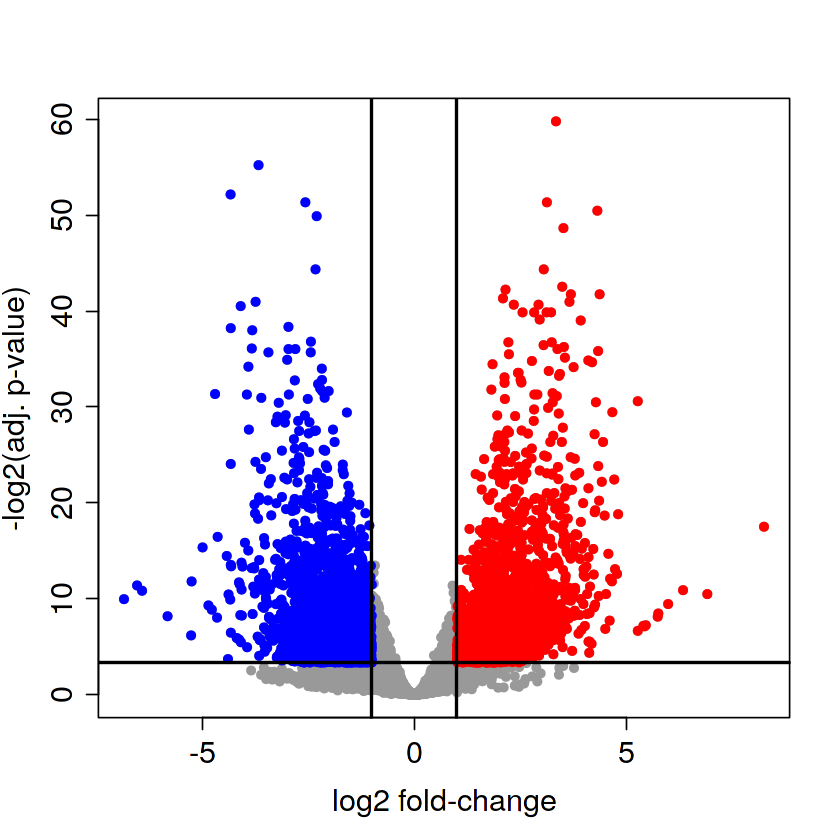

In [14]:
# Make a volcano plot by plotting the log2 fold-changes versus the adjusted p-values from resTable
plot(x = resTable$log2FoldChange, y = -log2(resTable$padj), pch = 16, col = 'grey60', xlab = 'log2 fold-change', ylab = '-log2(adj. p-value)', cex.axis = 1.5, cex.lab = 1.5)

# Overlay the same data from the differentially accessible peaks we found above
points(x = resTable.TAg_specific$log2FoldChange, y = -log2(resTable.TAg_specific$padj), pch = 16, col = 'red')
points(x = resTable.NAg_specific$log2FoldChange, y = -log2(resTable.NAg_specific$padj), pch = 16, col = 'blue')

# Add lines which show the fold-change and p-value cutoffs we used
abline(v = c(-1,1), lwd = 2)
abline(h = -log2(0.1), lwd = 2)

The above plot is useful because it also shows us the peaks which were deemed not differential in our analysis. These can be peaks that were:
* More than two-fold different but not statistically significant
* Statistically significant but less than two-fold different

We can also show the actual counts of the differential peaks
This will show how consistent the counts are accross replicates

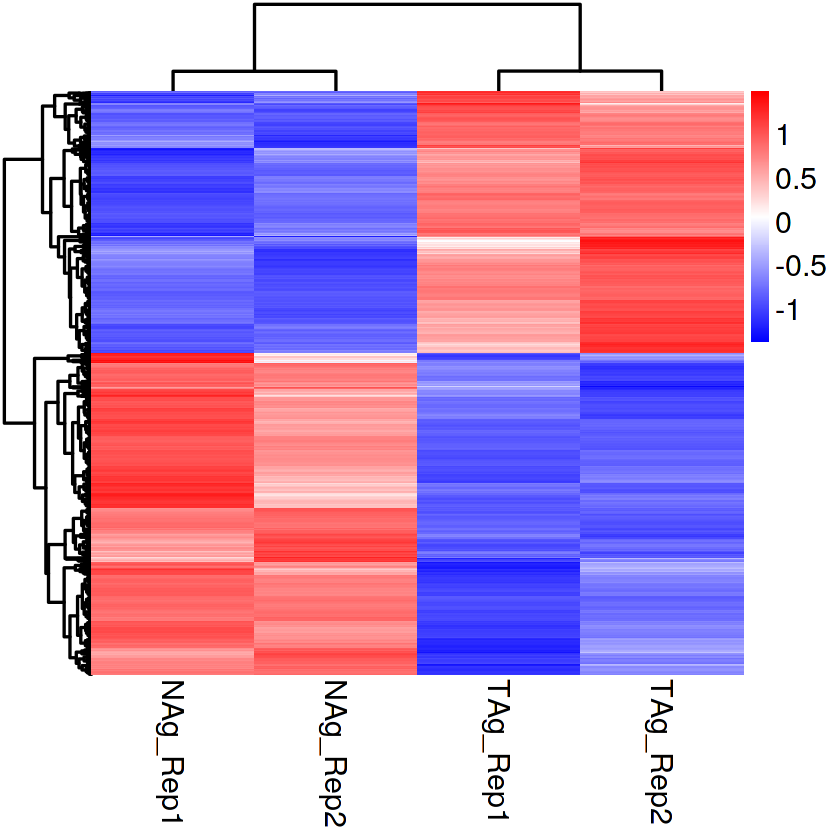

In [15]:
# Extract only the counts for the differential peak from the logCounts table we made earlier
diffPeak_counts<- logCounts[row.names(logCounts) %in% c(row.names(resTable.NAg_specific), row.names(resTable.TAg_specific)),]

# Transform the counts to the Z-Scale
zCounts<- t(scale(t(diffPeak_counts)))

# Show the results using a heatmap
pheatmap(zCounts, color = colorRampPalette(c('blue', 'white', 'red'))(256), show_rownames = FALSE, lwd = 2, fontsize = 18)